# Tutorial: Principal Component Analysis - modified from Neuromatch Academy

**This tutorial is based on Week 1, Day 4: Dimensionality Reduction By Neuromatch Academy which can be found here:**

https://compneuro.neuromatch.io/tutorials/W1D4_DimensionalityReduction/student/W1D4_Tutorial2.html

**The main difference is that we use the `sklearn` library instead of computating PCA on or own using linear algebra.**

---
# Tutorial Objectives

In this notebook we'll learn how to perform PCA by projecting the data onto a new basis (a new coordinate system). 

Overview:
- Calculate PCA.
- Perform PCA by projecting data onto the eigenvectors of the covariance matrix. 
- Plot and explore the eigenvalues.


---
# Setup


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Plotting Functions

def plot_eigenvalues(evals):
  """
  Plots eigenvalues.

  Args:
      (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """
  plt.figure(figsize=(4, 4))
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  plt.xticks(np.arange(1, len(evals) + 1))
  plt.ylim([0, 2.5])
  plt.show()

def plot_data(X):
  """
  Plots bivariate data. Includes a plot of each random variable, and a scatter
  scatter plot of their joint activity. The title indicates the sample
  correlation calculated from the data.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(X[:, 0], color='k')
  plt.ylabel('Neuron 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(X[:, 1], color='k')
  plt.xlabel('Sample Number (sorted)')
  plt.ylabel('Neuron 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(X[:, 0], X[:, 1], '.', markerfacecolor=[.5, .5, .5],
           markeredgewidth=0)
  ax3.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[:, 0], X[:, 1])[0, 1]))
  plt.show()


def plot_data_new_basis(Y):
  """
  Plots bivariate data after transformation to new bases. Similar to plot_data
  but with colors corresponding to projections onto basis 1 (red) and
  basis 2 (blue).
  The title indicates the sample correlation calculated from the data.

  Note that samples are re-sorted in ascending order for the first random
  variable.

  Args:
    Y (numpy array of floats) : Data matrix in new basis each column
                                corresponds to a different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(Y[:, 0], 'r')
  plt.ylabel('Projection \n basis vector 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(Y[:, 1], 'b')
  plt.xlabel('Sample number')
  plt.ylabel('Projection \n basis vector 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(Y[:, 0], Y[:, 1], '.', color=[.5, .5, .5])
  ax3.axis('equal')
  plt.xlabel('Projection basis vector 1')
  plt.ylabel('Projection basis vector 2')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(Y[:, 0], Y[:, 1])[0, 1]))
  plt.show()


def plot_basis_vectors(X, W):
  """
  Plots bivariate data as well as new basis vectors.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    W (numpy array of floats) : Square matrix representing new orthonormal
                                basis each column represents a basis vector

  Returns:
    Nothing.
  """

  plt.figure(figsize=[4, 4])
  plt.plot(X[:, 0], X[:, 1], '.', color=[.5, .5, .5], label='Data')
  plt.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.plot([0, W[0, 0]], [0, W[1, 0]], color='r', linewidth=3,
           label='Basis vector 1')
  plt.plot([0, W[0, 1]], [0, W[1, 1]], color='b', linewidth=3,
           label='Basis vector 2')
  plt.legend()
  plt.show()

In [4]:
# @title Helper functions

def get_data(cov_matrix):
  """
  Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian

  Note that samples are sorted in ascending order for the first random
  variable.

  Args:
    var_1 (scalar)                     : variance of the first random variable
    var_2 (scalar)                     : variance of the second random variable
    cov_matrix (numpy array of floats) : desired covariance matrix

  Returns:
    (numpy array of floats)            : samples from the bivariate Gaussian,
                                          with each column corresponding to a
                                          different random variable
  """

  mean = np.array([0, 0])
  X = np.random.multivariate_normal(mean, cov_matrix, size=1000)
  #indices_for_sorting = np.argsort(X[:, 0])
  #X = X[indices_for_sorting, :]
  return X


def calculate_cov_matrix(var_1, var_2, corr_coef):
  """
  Calculates the covariance matrix based on the variances and
  correlation coefficient.

  Args:
    var_1 (scalar)         :  variance of the first random variable
    var_2 (scalar)         :  variance of the second random variable
    corr_coef (scalar)     :  correlation coefficient

  Returns:
    (numpy array of floats) : covariance matrix
  """
  cov = corr_coef * np.sqrt(var_1 * var_2)
  cov_matrix = np.array([[var_1, cov], [cov, var_2]])
  return cov_matrix


---
# 1. Compute the PCA weights

To illustrate how PCA works, we first generate some surrogate data samples from a bivariate, zero-mean Gaussian distribution.


[[1.  0.8]
 [0.8 1. ]]


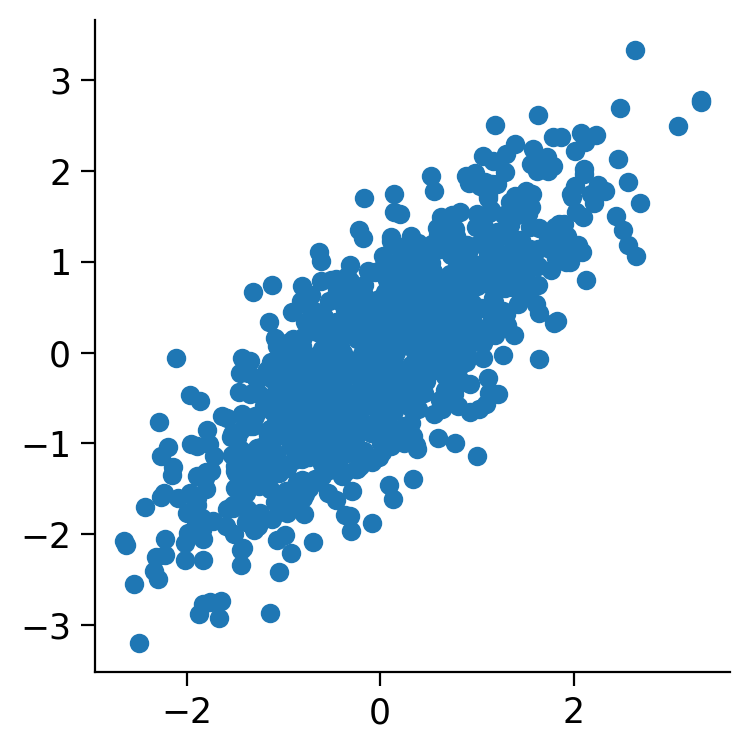

In [5]:
variance_1 = 1
variance_2 = 1
corr_coef = 0.8

# Calculate covariance matrix
cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
print(cov_matrix)

# Generate data with that covariance matrix
X = get_data(cov_matrix)
X = X - np.mean(X)

plt.figure(figsize=[4, 4])
plt.scatter(X[:,0],X[:,1])
plt.show()


To perform PCA, we will project the data onto the eigenvectors of the covariance matrix, i.e.,:

\begin{equation}
\bf S = X W
\end{equation}

where $\bf S$ is an $N_\text{samples} \times N$ matrix representing the projected data (also called *scores*), and $\bf W$ is an $N\times N$ orthogonal matrix, each of whose columns represents the eigenvectors of the covariance matrix (also called *weights* or *loadings*). 

To compute the weight matrix $\bf W$, you can simple use `PCA` from `sklearn.decomposition`.

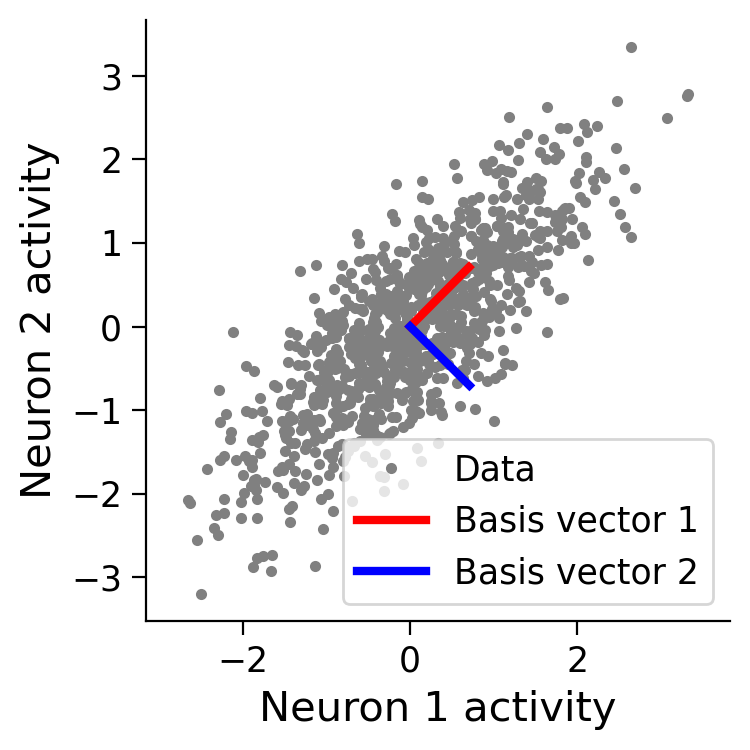

In [6]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)

weights = pca.components_         # principal components coefficients, also called weights or loadings

plot_basis_vectors(X, weights.T)


# 2. Perform PCA by projecting data using the weight matrix

Let's now perform PCA on the data - mathematically, this corresponds to projecting the data onto the eigenvectors of its covariance matrix.


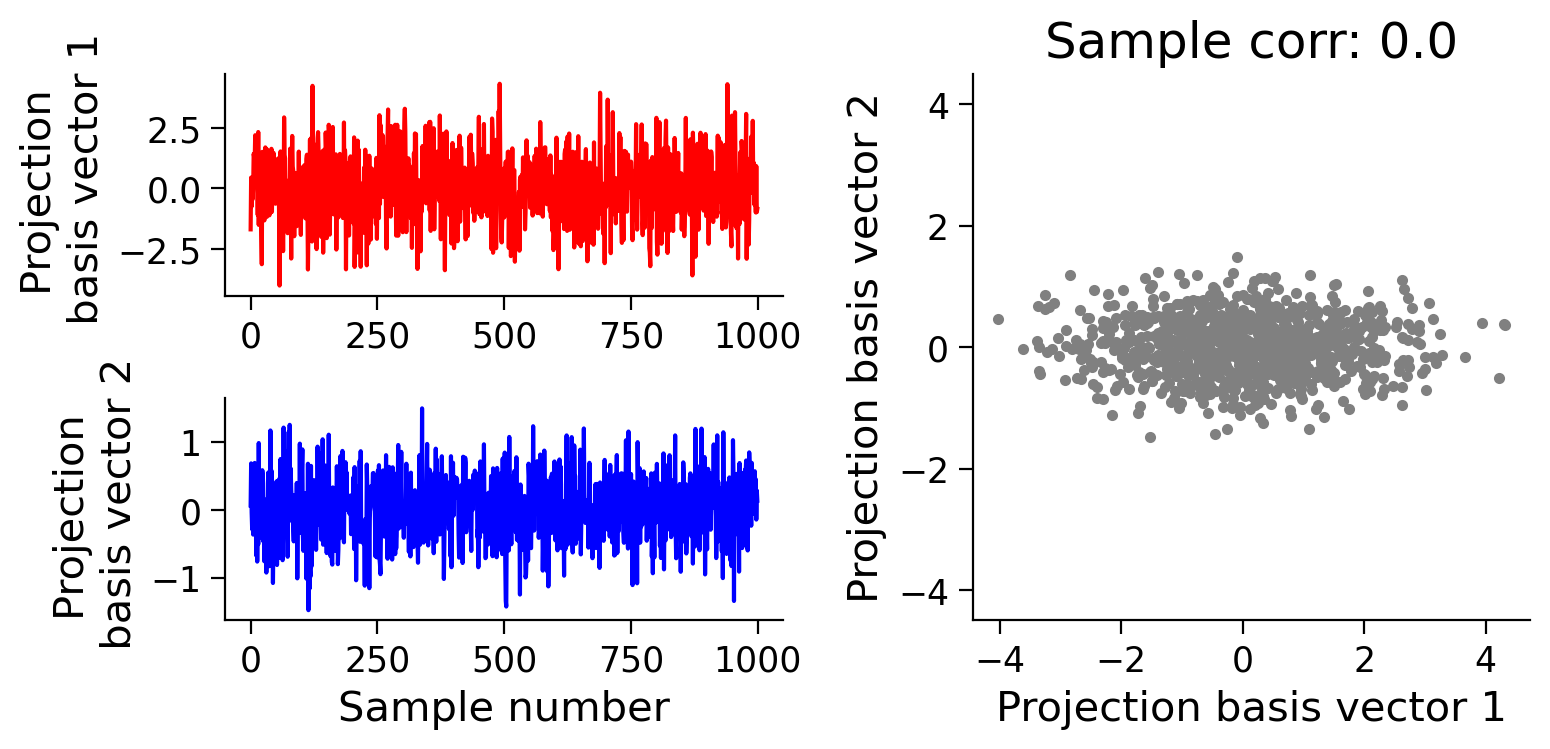

In [7]:

scores = pca.transform(X)         # projected data (also called the principal components or PCs)
# Note that this is the same as scores = np.matmul(X,weights)

evals = pca.explained_variance_   # eigenvalues of the covariance matrix

# Plot the data projected into the new basis
plot_data_new_basis(scores)

   Finally, we will examine the eigenvalues of the covariance matrix. Remember that each eigenvalue describes the variance of the data projected onto its corresponding eigenvector. This is an important concept because it allows us to rank the PCA basis vectors based on how much variance each one can capture. First run the code below to plot the eigenvalues (sometimes called the "scree plot"). Which eigenvalue is larger?

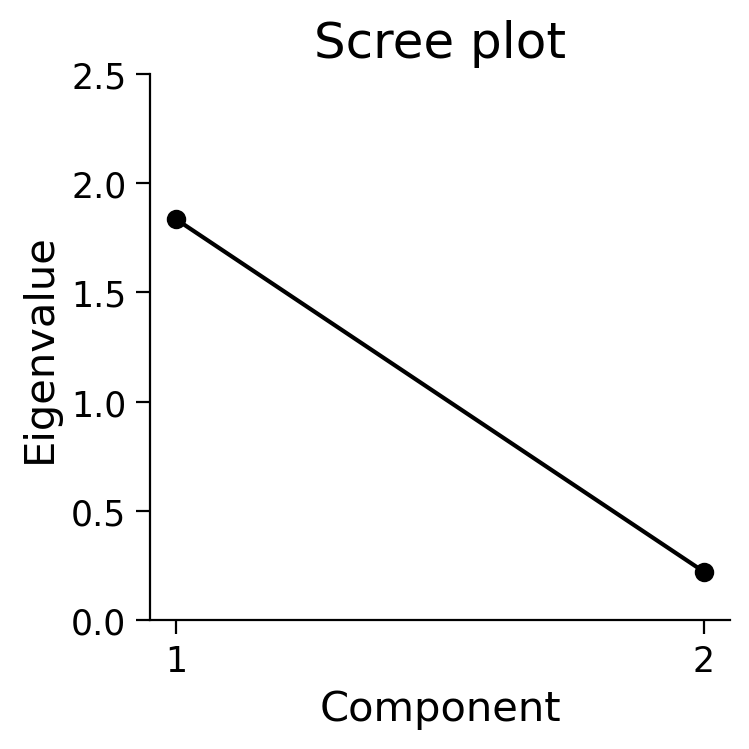

In [8]:
plot_eigenvalues(evals)

# 3. Interactive Demo: Exploration of the correlation coefficient

Run the following cell and use the slider to change the correlation coefficient in the data. You should see the scree plot and the plot of basis vectors updated.

1.  What happens to the eigenvalues as you change the correlation coefficient?
2.  Can you find a value for which both eigenvalues are equal?
3.  Can you find a value for which only one eigenvalue is nonzero?

In [9]:
# @markdown Make sure you execute this cell to enable the widget!

def refresh(corr_coef=.8):
  cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
  X = get_data(cov_matrix)
  pca = PCA()
  pca.fit(X)
  evectors = pca.components_  # principal components coefficients
  score = pca.transform(X)  # data projected into the subspace 
  evals = pca.explained_variance_  # eigenvalues of the covariance matrix
  plot_eigenvalues(evals)
  plot_basis_vectors(X, evectors.T)
_ = widgets.interact(refresh, corr_coef=(-1, 1, .1))

interactive(children=(FloatSlider(value=0.8, description='corr_coef', max=1.0, min=-1.0), Output()), _dom_clas…

---
# Summary

- In this tutorial, we learned that the goal of PCA is to find a new basis capturing the directions of maximum variance of the data. More precisely, the $i$th basis vector is the direction that maximizes the projected variance, while being orthogonal to all previous basis vectors. Mathematically, these basis vectors are the eigenvectors of the covariance matrix (also called *loadings*). 
- PCA also has the useful property that the projected data (*scores*) are uncorrelated.
- The projected variance along each basis vector is given by its corresponding eigenvalue. This is important because it allows us to rank the "importance" of each basis vector in terms of how much of the data variability it explains. An eigenvalue of zero means there is no variation along that direction so it can be dropped without losing any information about the original data.
- We will use this property to reduce the dimensionality of high-dimensional data in Assignment 5.
